# Evaluate different methods

In this notebook, we will evaluate how capable different methods for finding named entities in OCR document texts are. At the end of the notebook, we will select one of the methods that is sufficiently fast and accurate.

## Preliminaries

We will begin with a bit of boilerplate, logging information and setting up the computational environment.

In [1]:
! hostname

apollo.fi.muni.cz


In [2]:
! python -V

Python 3.8.5


Install the current version of the package and its dependencies.

In [3]:
%%capture
! pip install .

Make sure numpy does not parallelize.

In [4]:
import os

In [5]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

Pick the GPU that we will use.

In [6]:
! nvidia-smi -L

GPU 0: NVIDIA A40 (UUID: GPU-177e5a84-366f-6464-1bbb-908f2dd979cc)
GPU 1: Tesla T4 (UUID: GPU-cf4e7061-619f-5b3b-a217-410f6d506d62)
GPU 2: Tesla T4 (UUID: GPU-00386b4a-741a-aac4-b833-b678a811936f)
GPU 3: Tesla T4 (UUID: GPU-10531c8c-13c3-8e82-302b-91a5615701d6)
GPU 4: Tesla T4 (UUID: GPU-82eac985-cf18-1379-cbcc-e8d71246e28c)
GPU 5: Tesla T4 (UUID: GPU-552f5db8-cec9-3733-3394-17c1ecbc8b85)
GPU 6: Tesla T4 (UUID: GPU-7d2ad51d-6c12-c878-1a30-a21a7fe9c7bd)
GPU 7: Tesla T4 (UUID: GPU-81bd2022-c6f6-4a67-d3f3-f461591e20ab)
GPU 8: Tesla T4 (UUID: GPU-4f6616fb-96e0-adbd-6ee5-7b6146de8ece)
GPU 9: Tesla T4 (UUID: GPU-197d3f17-6807-d6d8-a31c-f54ef78bcb2d)
GPU 10: Tesla T4 (UUID: GPU-e36ec7af-fa51-2498-6bb9-1f2e57bed4c5)
GPU 11: NVIDIA A100 80GB PCIe (UUID: GPU-2d25d82d-c487-73b0-9341-82e74253106e)
GPU 12: Tesla T4 (UUID: GPU-4195d034-0e80-bd51-3c68-3069d48177db)
GPU 13: Tesla T4 (UUID: GPU-030e587b-ae70-3854-4a86-b888f04de428)
GPU 14: Tesla T4 (UUID: GPU-c450823e-5524-7032-228b-140b3187d733)
GPU 1

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "14"

Set up logging to display informational messages.

In [8]:
import logging
import sys

In [9]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(message)s')

## Load documents and entities

First, we will load all documents and entities.

In [10]:
from ahisto_named_entity_search.entity import Entity, Person, Place, load_entities

In [11]:
all_entities = load_entities()

Loading entities: 100%|███████████| 4182/4182 [00:05<00:00, 793.86it/s]

Loaded 20508 entities: 4350 places (21.21%) and 16158 persons (78.79%).


In [12]:
from ahisto_named_entity_search.document import Document, load_documents

In [13]:
documents = load_documents()

Loading documents: 100%|████| 268669/268669 [00:06<00:00, 40200.07it/s]


## Take a subset of entities for evaluation

Next, we will find the shortest and longest entities.
``` python
>>> def entity_length(entity): return len(str(entity))
```

We need to filter out too short entities, because they often contain only connectives, punctiation, numerals, etc.:
``` python
>>> sorted(all_entities, key=entity_length)[:58][-3:]
[Person: a, Person: (, Place: a, Person: hy, Person: XL]

>>> sorted(all_entities, key=entity_length)[:58][-3:]
[Person: Iva, Place: Háj, Person: Ota]
```

In [14]:
shortest_entities = [
    Person('Iva'),
    Place('Háj'),
    Person('Ota'),
]

We also need to filter out too long entities, because they are often composed of several entities:

```python
>>> sorted(all_entities, key=entity_length)[-1]
Person: Coln, Ach, Meincz, Worms, Straßburg, Basel, Hagnaw und den andern stetten in Ellseßen, Zurich, Luczern, Solottern, Mulhawsen, Northawsen, Frankfurt, Geylnhawsen, Fridberg, Winsheim, Sweinfurt, Ulme und die mit in in einung sein, Costencz und die mit in in einung sein, Freyburg in Uechtland, Freyburg in Preisgew, Preisach, Newemburg, Augspurg, Regenspurg, Eger, Heylprunnen, Wimpfen, Erffurd.

>>> sorted(all_entities, key=entity_length)[-146:][:3]
[Person: Fridrichen marggrafen zu Brandemburg des heiligen Romischen reichs ercamrer und burggrafen zu Nuremberg,
 Person: paní Kláře Zalcarové, měštce v Olomúci i její erbom i tomu, kdož by tento list měl s jejich dobrú vuolí,
 Person: Markéta, vdova po Buškovi z Rýzmberku, Janem a Bohuslavem, jejími syny z Blažimi sezením na hradě Bubnu]
```

In [15]:
longest_entities = [
    Person('Fridrichen marggrafen zu Brandemburg des heiligen Romischen reichs ercamrer und burggrafen zu Nuremberg'),
    Person('paní Kláře Zalcarové, měštce v Olomúci i její erbom i tomu, kdož by tento list měl s jejich dobrú vuolí'),
    Person('Markéta, vdova po Buškovi z Rýzmberku, Janem a Bohuslavem, jejími syny z Blažimi sezením na hradě Bubnu'),
]

Next, we will find entities in different single languages:
``` python
>>> ! pip install langdetect
>>> from langdetect import detect_langs, LangDetectException
>>> from collections import defaultdict
>>> import random
>>> entities_languages = defaultdict(lambda: list())
>>> for entity in random.sample(all_entities, k=len(all_entities)):
...     try:
...         best_lang, *other_langs = detect_langs(str(entity))
...         if len(other_langs) == 0:
...             entities_languages[best_lang.lang].append(entity)
...     except LangDetectException:
...         continue

>>> entities_languages['de'][:3]
[Person: Bischoff zu Wirtzpurg,
 Place: in Trebicz,
 Person: Weissenburg in Bayern]  # Notice the wrong designation as a Person instead of a Place.

>>> entities_languages['cs'][:3]
[Place: kromě rybníka v velikého v Slatinie,
 Person: Václava Králíka z Buřenic, tehdy správce olomouckého kostela a antiochijského patriarchy,
 Person: Břeňka z Drštky]

>>> entities_languages['it'][:3]
[Person: Imperatori Sigismundo,
 Person: Wladislaus dei gratia rex Polonie et cetera,
 Person: Brandou da Castiglione]
```

In [16]:
german_entities = [
    Person('Bischoff zu Wirtzpurg'),
    Place('in Trebicz'),
    Person('Weissenburg in Bayern'),
]

In [17]:
czech_entities = [
    Place('kromě rybníka v velikého v Slatinie'),
    Person('Václava Králíka z Buřenic, tehdy správce olomouckého kostela a antiochijského patriarchy'),
    Person('Břeňka z Drštky'),
]

In [18]:
latin_entities = [
    Person('Imperatori Sigismundo'),
    Person('Wladislaus dei gratia rex Polonie et cetera'),
    Person('Brandou da Castiglione'),
]

Next, we will find entities of different types:
``` python
>>> import random
>>> places = [entity for entity in sorted(all_entities) if isinstance(entity, Place)]
>>> persons = [entity for entity in sorted(all_entities) if isinstance(entity, Person)]
>>> random.choices(places, k=3)
[
    'Kutná Hora',
    'pražského kostela',
    'Těšeticích',
]
>>> random.choices(persons, k=3)
[
    'Aleš z Vrahovic',
    'králem Zikmundem',
    'husité',
]
```

In [19]:
place_entities = [
    Place('Kutná Hora'),
    Place('pražského kostela'),
    Place('Těšeticích'),
]

In [20]:
person_entities = [
    Person('Aleš z Vrahovic'),
    Person('králem Zikmundem'),
    Person('husité'),
]

We will combine the sampled entities into a single list:

In [21]:
entities = shortest_entities + longest_entities + german_entities + czech_entities + latin_entities + place_entities + person_entities

In [22]:
for entity in entities:
    assert entity in all_entities, entity

In [23]:
print(f'We sampled {len(entities)} entities.')

We sampled 21 entities.


We will also combine the sampled entities into a dict structured into categories and subcategories to be used in the evaluation.

In [24]:
entity_categories = {
    'Length': {
        'Shortest': shortest_entities,
        'Longest': longest_entities,
    },
    'Language': {
        'German': german_entities,
        'Czech': czech_entities,
        'Latin': latin_entities,
    },
    'Type': {
        'Place': place_entities,
        'Person': person_entities,
    },
    'All': {
        None: entities,
    },
}

In [25]:
unique_entity_categories = set()

for category in entity_categories:
    for subcategory in entity_categories[category]:
        for entity in entity_categories[category][subcategory]:
            assert entity in all_entities, entity
            unique_entity_categories.add(entity)

assert len(unique_entity_categories) == len(entities), num_entity_categories

In the evaluation, we exclude the entity \`\`Iva'' from the overall evaluation, because it produces a large number of results that are affected by OCR errors.

In [26]:
entity_categories['All'][None] = [
    entity
    for entity
    in entities
    if entity != Person('Iva')
]

## Compute and save search results

After we have selected a subset of entities, we will search for the entities in OCR texts. We will try a number of methods, some of which will be indexpensive and will serve to select candidates for expensive methods that will produce the final results.

In [27]:
from json import JSONDecodeError

In [28]:
from ahisto_named_entity_search.search import Search
from ahisto_named_entity_search.search import SearchResultList

### Inexpensive Methods

First, we will use a number of inexpensive and less accurate methods to select candidate results for the more expensive and accurate methods.

#### Jaccard Similarity

First, we will slide a window across the OCR texts and we will exhaustively compute the Jaccard index between each entity and each window. We will consider sets of character N-grams as well as sets of words. Due to the low number of OCR texts and the constant time complexity of the Jaccard index, this is computationally feasible. This method accurately detects the position of an entity in a text, but the precision of the Jaccard index on the semantic text similarity task is low.

In [29]:
from ahisto_named_entity_search.index import CharacterJaccardSimilarityIndex

In [30]:
try:
    jaccard_similarity_character_results = SearchResultList.load('character-jaccard-similarity', entities)
except (IOError, JSONDecodeError):
    jaccard_similarity_character_results = Search(CharacterJaccardSimilarityIndex(documents.values())).search(entities)
    jaccard_similarity_character_results.save('character-jaccard-similarity')
print(jaccard_similarity_character_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/character-jaccard-similarity.json
Retrieved 210000 results for 21 entities (10000.00 on average, 10000 at minimum) in 23 hours using CharacterJaccardSimilarityIndex.


In [31]:
from ahisto_named_entity_search.index import WordJaccardSimilarityIndex

In [32]:
try:
    jaccard_similarity_word_results = SearchResultList.load('word-jaccard-similarity', entities)
except (IOError, JSONDecodeError):
    jaccard_similarity_word_results = Search(WordJaccardSimilarityIndex(documents.values())).search(entities)
    jaccard_similarity_word_results.save('word-jaccard-similarity')
print(jaccard_similarity_word_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/word-jaccard-similarity.json
Retrieved 137169 results for 21 entities (6531.86 on average, 7 at minimum) in 23 hours using WordJaccardSimilarityIndex.


#### Okapi BM25

Next, we will again slide a window across the OCR text and we will extract and index passages using an Okapi BM25 vector space model. Due to the low number of OCR texts and the constant time complexity of vector space models, this is computationally feasible. This method accurately detects the position of an entity in a text, but Okapi BM25 requires tokenization into words, which results in poor precision on OCR texts.

In [33]:
from ahisto_named_entity_search.index import OkapiBM25Index

In [34]:
try:
    okapi_bm25_results = SearchResultList.load('okapi-bm25', entities)
except (IOError, JSONDecodeError):
    okapi_bm25_results = Search(OkapiBM25Index(documents.values())).search(entities)
    okapi_bm25_results.save('okapi-bm25')
print(okapi_bm25_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/okapi-bm25.json
Retrieved 137169 results for 21 entities (6531.86 on average, 7 at minimum) in 17 hours using OkapiBM25Index.


#### Fuzzy Regexes

Next, we will try to find exact and almost-exact matches of the entities in the OCR texts using [fuzzy regexes][1]. Fuzzy regexes offer high precision, but low recall, since only exact and almost-exact character-level matches will be found. Unlike the Jaccard index, fuzzy regexes don't use a sliding window: a properly-sized window with a match is automatically found in a full document. Almost-exact matches can be produced by allowing a small number of errors; a allowing a larger number of errors is not computationally feasible, because the time complexity is quadratic in the number of errors. To ensure that almost-exact matches can be found even for long entities, we divide them into shorter spans of text and search for them separately.

 [1]: https://pypi.org/project/regex/#approximate-fuzzy-matching-hg-issue-12-hg-issue-41-hg-issue-109

In [35]:
from ahisto_named_entity_search.index import FuzzyRegexIndex

In [36]:
try:
    fuzzy_regex_results = SearchResultList.load('fuzzy-regex', entities)
except (IOError, JSONDecodeError):
    fuzzy_regex_results = Search(FuzzyRegexIndex(documents.values())).search(entities)
    fuzzy_regex_results.save('fuzzy-regex')
print(fuzzy_regex_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/fuzzy-regex.json
Retrieved 34416 results for 21 entities (1638.86 on average, 0 at minimum) in a day using FuzzyRegexIndex.


#### Manatee

Finally, we will try to find exact and almost-exact matches of the entities in the OCR texts using the boolean retrieval search engine of [Manatee][1]. Manatee offers high precision, but low recall, since only exact and almost-exact matches will be found. Unlike the Jaccard index and like fuzzy regexes, Manatee does not use a sliding window: a properly-sized window with a match is automatically found in a full document using a positional inverted index. Almost-exact matches are produced by applying Czech lemmatization to both the queries and the documents.

 [1]: https://nlp.fi.muni.cz/trac/noske#manatee

In [37]:
from ahisto_named_entity_search.index import RemoteManateeIndex

In [38]:
try:
    manatee_results = SearchResultList.load('manatee', entities)
except (IOError, JSONDecodeError):
    manatee_results = Search(RemoteManateeIndex(documents.values())).search(entities)
    manatee_results.save('manatee')
print(manatee_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/manatee.json
Retrieved 678 results for 21 entities (32.29 on average, 0 at minimum) in 46 seconds using RemoteManateeIndex.


### Expensive Methods

Next, we will use the results produced by the inexpensive and less accurate methods as candidate results to be reranked by the expensive and accurate methods:

In [39]:
inexpensive_candidates = [
    jaccard_similarity_character_results,
    jaccard_similarity_word_results,
    okapi_bm25_results,
    fuzzy_regex_results,
    manatee_results,
]

#### Edit Distance

First, we will rerank the candidate results using the character and word error rate. This is necessary, because the edit distance has quadratic time complexity in the text size, which makes it extremely *expensive*. If at least some of the candidate results are representative, the edit distance offers moderate precision on the semantic text similarity task.

In [40]:
from ahisto_named_entity_search.index import CharacterEditSimilarityIndex

In [41]:
try:
    edit_similarity_character_results = SearchResultList.load('character-edit-similarity', entities)
except (IOError, JSONDecodeError):
    edit_similarity_character_results = Search(CharacterEditSimilarityIndex(inexpensive_candidates)).search(entities)
    edit_similarity_character_results.save('character-edit-similarity')
print(edit_similarity_character_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/character-edit-similarity.json
Retrieved 209478 results for 21 entities (9975.14 on average, 9514 at minimum) in 5 minutes using CharacterEditSimilarityIndex.


In [42]:
from ahisto_named_entity_search.index import WordEditSimilarityIndex

In [43]:
try:
    edit_similarity_word_results = SearchResultList.load('word-edit-similarity', entities)
except (IOError, JSONDecodeError):
    edit_similarity_word_results = Search(WordEditSimilarityIndex(inexpensive_candidates)).search(entities)
    edit_similarity_word_results.save('word-edit-similarity')
print(edit_similarity_word_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/word-edit-similarity.json
Retrieved 131398 results for 21 entities (6257.05 on average, 7 at minimum) in a minute using WordEditSimilarityIndex.


#### BERTScore

Next, we will also rerank the candidate results using the [BERT F-Score][1]. Although originally designed for neural machine translation evaluation, the BERT F₁-Score is a symmetric similarity measure. Unlike the edit distance, which still measures mostly syntactic similarity, the BERT F₁-Score offers excellent precision on the semantic text similarity task.

 [1]: https://arxiv.org/abs/1904.09675

In [44]:
from ahisto_named_entity_search.index import BERTScoreIndex

In [45]:
try:
    bert_score_results = SearchResultList.load('bert-score', entities)
except (IOError, JSONDecodeError):
    import transformers
    transformers.logging.set_verbosity_error()
    bert_score_results = Search(BERTScoreIndex(inexpensive_candidates), num_workers=6).search(entities)
    bert_score_results.save('bert-score')
print(bert_score_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/bert-score.json
Retrieved 210000 results for 21 entities (10000.00 on average, 10000 at minimum) in 9 minutes using BERTScoreIndex.


#### SentenceBERT

Finally, we will also rerank the candidate results using the cosine similarity between [siamese BERT][1] embeddings. Like the BERT F₁-Score, the siamese BERT embeddings offer excellent precision on the semantic text similarity task.

 [1]: https://arxiv.org/abs/1908.10084

In [46]:
from ahisto_named_entity_search.index import SentenceBERTSimilarityIndex

In [47]:
try:
    sentence_bert_similarity_results = SearchResultList.load('sbert-similarity', entities)
except (IOError, JSONDecodeError):
    logging.getLogger('sentence_transformers.SentenceTransformer').setLevel(logging.WARNING)
    sentence_bert_similarity_results = Search(SentenceBERTSimilarityIndex(inexpensive_candidates), num_workers=1).search(entities)
    sentence_bert_similarity_results.save('sbert-similarity')
print(sentence_bert_similarity_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/sbert-similarity.json
Retrieved 210000 results for 21 entities (10000.00 on average, 10000 at minimum) in 11 minutes using SentenceBERTSimilarityIndex.


### Rank Fusion

Finally, we will use rank fusion to combine the results of all the above methods.

In [48]:
expensive_candidates = [
    edit_similarity_character_results,
    edit_similarity_word_results,
    bert_score_results,
    sentence_bert_similarity_results,
]

In [49]:
candidates = inexpensive_candidates + expensive_candidates

#### Reciprocal Rank Fusion

First, we will use [the reciprocal rank fusion (RRF)][1] to combine the results of all the above methods.

 [1]: https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf

In [50]:
from ahisto_named_entity_search.index import ReciprocalRankFusionIndex

In [51]:
try:
    reciprocal_rank_fusion_results = SearchResultList.load('reciprocal-rank-fusion', entities)
except (IOError, JSONDecodeError):
    reciprocal_rank_fusion_results = Search(ReciprocalRankFusionIndex(candidates)).search(entities)
    reciprocal_rank_fusion_results.save('reciprocal-rank-fusion')
print(reciprocal_rank_fusion_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/reciprocal-rank-fusion.json
Retrieved 210000 results for 21 entities (10000.00 on average, 10000 at minimum) in 29 seconds using ReciprocalRankFusionIndex.


#### Concatenation

Next, we will concatenate the results of the highly precise fuzzy regexes and the results of the RRF. In other words: If there are results from the fuzzy regexes, we will return them. Otherwise, we will fall back to the results of the RRF, which can be more of a mixed bag.

In [52]:
from ahisto_named_entity_search.index import ConcatenatedIndex

In [53]:
try:
    concatenated_index_results = SearchResultList.load('fuzzy-regex-and-reciprocal-rank-fusion', entities)
except (IOError, JSONDecodeError):
    concatenated_index_results = Search(ConcatenatedIndex([fuzzy_regex_results, reciprocal_rank_fusion_results])).search(entities)
    concatenated_index_results.save('fuzzy-regex-and-reciprocal-rank-fusion')
print(concatenated_index_results)

Loaded /nlp/projekty/ahisto/public_html/named-entity-search/results/fuzzy-regex-and-reciprocal-rank-fusion.json
Retrieved 210000 results for 21 entities (10000.00 on average, 10000 at minimum) in 23 seconds using ConcatenatedIndex.


## Annotate the search results

After we have gathered all the search results, we will produce a spreadsheet and pass it to annotators.

In [54]:
all_results = candidates + [reciprocal_rank_fusion_results, concatenated_index_results]

In [55]:
from ahisto_named_entity_search.search import Annotations

In [56]:
Annotations.create_annotation_template('annotation-template.xlsx', entities, all_entities, all_results)

## Evaluate the search results

Using the annotations, we can now determine how capable the methods are using precision and recall. To decide the best search engine, we compute the weighted harmonic mean [the $F_\beta$-score][1], where $\beta = 0.25$ so that precision is given four times more weight than recall.

 [1]: https://en.wikipedia.org/wiki/F-score

In [57]:
annotations = Annotations('annotations.xlsx', entities, documents)

In [58]:
from collections import defaultdict
from typing import Dict, Tuple, List, Optional

from ahisto_named_entity_search.search import IrEvaluationResult

In [59]:
precisions: Dict[str, Tuple[List[float]]] = defaultdict(list)
recalls: Dict[str, Tuple[List[float]]] = defaultdict(list)
f_scores: Dict[str, Tuple[List[float]]] = defaultdict(list)

index: List[Tuple[str, Optional[str]]] = list()

for category in entity_categories:
    for subcategory in entity_categories[category]:
        index.append((category, subcategory))
        for result_list in all_results:
            evaluation = IrEvaluationResult(result_list, annotations, entity_categories[category][subcategory])
            precisions[result_list.index_name].append(evaluation.precision)
            recalls[result_list.index_name].append(evaluation.recall)
            f_scores[result_list.index_name].append(evaluation.f_score)

In [60]:
import pandas as pd
from pandas import DataFrame, MultiIndex

In [61]:
columns = MultiIndex.from_tuples(index, names=('Category', 'Subcategory'))

### Precision

Manatee achieved the best precision in all categories except *Longest*, where it retrieved no results. It also achieved the perfect 100% precision in all categories except *Longest* and *Shortest*. The second and third best systems on average in terms of precision are fuzzy regexes and Jaccard similarity.

In [62]:
precision_df = DataFrame.from_dict(precisions, orient='index', columns=columns)
precision_df = precision_df.sort_values(by=('All', None), ascending=False)
precision_df = precision_df.apply(lambda data: 100.0 * data)
precision_df.style.format('{:.2f}%')

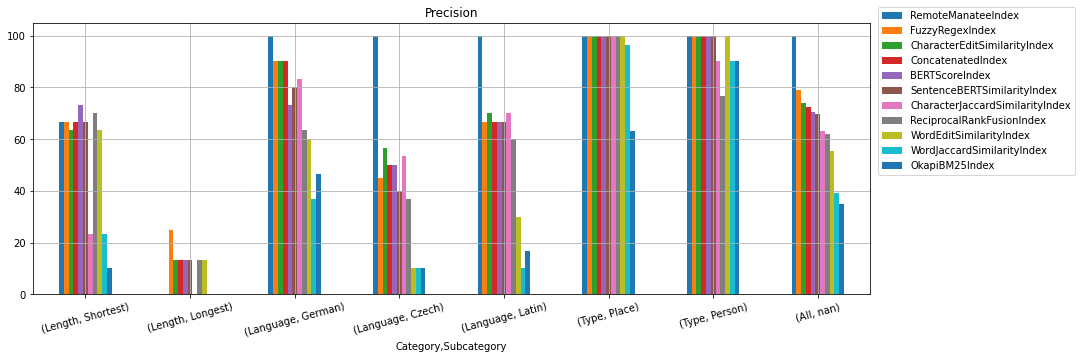

In [63]:
_ = precision_df.T.plot.bar(title='Precision', rot=15, figsize=(15, 5), grid=True).legend(loc=(1.01, 0.44))

### Recall

Edit distance received the best recall, closely followed by fuzzy regexes concatenated with reciprocal rank fusion, BERT F₁-Score, and a tie between fuzzy regexes and SentenceBERT embeddings.

In [64]:
recall_df = DataFrame.from_dict(recalls, orient='index', columns=columns)
recall_df = recall_df.sort_values(by=('All', None), ascending=False)
recall_df = recall_df.apply(lambda data: 100.0 * data)
recall_df.style.format('{:.2f}%')

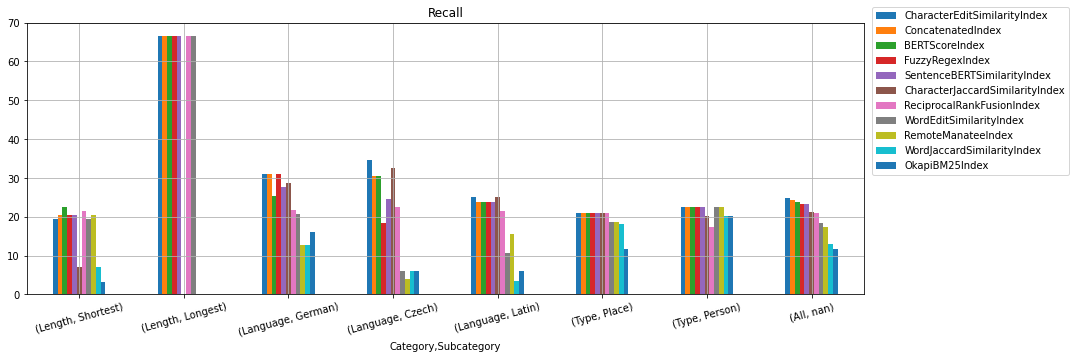

In [65]:
_ = recall_df.T.plot.bar(title='Recall', rot=15, figsize=(15, 5), grid=True).legend(loc=(1.01, 0.44))

### $F_\beta$-score

Manatee received the best $F_\beta$-score and placed well ahead of the second fuzzy regexes, which were closely followed by the edit distance.

In [66]:
f_score_df = DataFrame.from_dict(f_scores, orient='index', columns=columns)
f_score_df = f_score_df.sort_values(by=('All', None), ascending=False)
f_score_df = f_score_df.apply(lambda data: 100.0 * data)
f_score_df.style.format('{:.2f}%')

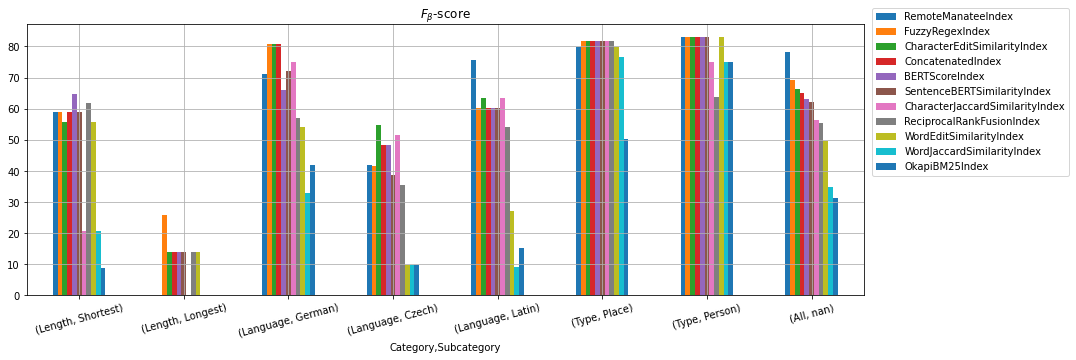

In [67]:
_ = f_score_df.T.plot.bar(title=r'$F_\beta$-score', rot=15, figsize=(15, 5), grid=True).legend(loc=(1.01, 0.44))

We decided to use Manatee to produce our dataset for training named entity recognition models. As our second choice, we will use fuzzy regexes due to their higher recall.